# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable

from torchvision import datasets, transforms
import torchvision

import sys, os
import matplotlib.pyplot as plt

import resnet

from utils import create_train_data_loader, create_test_data_loader
from utils import Cifar10SearchDataset
from utils import train_transforms, test_transforms
from utils import display_mis_images 
from utils import learning_r_finder
from utils import OneCycleLR_policy

from calc_loss_accuracy import model_training, model_testing_old#, model_testing 
from plots import plot_losses,plot_images 

import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.8/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
### this is for running in local ###
try:
    os.environ['HTTP_PROXY']='http://185.46.212.90:80'
    os.environ['HTTPS_PROXY']='http://185.46.212.90:80'
    print ("proxy_exported")
except:
    None

proxy_exported


In [3]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)
    
device = torch.device("cuda" if cuda else "cpu")
print(device)

CUDA Available? True
cuda


# Train/Test Data Loaders with Transformation

In [4]:
means = [0.4914, 0.4822, 0.4465]
stds = [0.2470, 0.2435, 0.2616]

train_transforms = train_transforms(means, stds)
test_transforms = test_transforms(means, stds)

train = Cifar10SearchDataset('./data', train=True, download=True, transform=train_transforms)
test = Cifar10SearchDataset('./data', train=False, download=True, transform=test_transforms)

dataloader_args = dict(shuffle=True, batch_size=512, num_workers=0, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

Files already downloaded and verified
Files already downloaded and verified


# Model Params, optimizer, loss criterion and model summary
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [5]:
m = resnet.ResNet18().to(device)
optimizer = optim.Adam(m.parameters(), lr=0.001, weight_decay=1e-3)
criterion = nn.CrossEntropyLoss()
summary(m, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

## Calculating the max and min LR using one cycle LR policy

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.83E-03


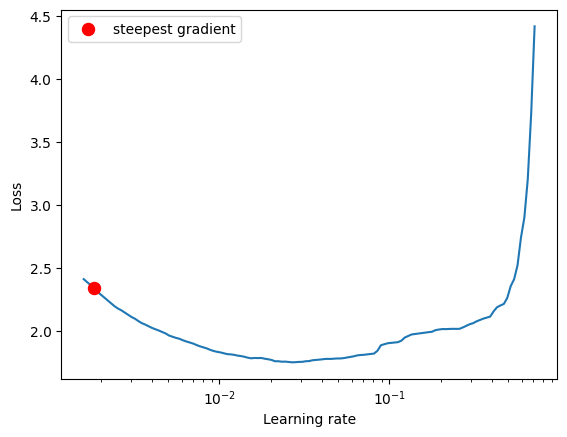

In [6]:
 # to reset the model and optimizer to their initial state
learning_r_finder(m,optimizer,criterion, device, train_loader, n_iters=200,  end_lr=10)
# sys.exit()

# Let's Train and test our model
### using one cycle lr policy

In [7]:
EPOCHS = 20
scheduler = OneCycleLR_policy(optimizer,train_loader,EPOCHS,peak_value=5.0,div_factor=100,final_div_factor=100,max_lr=1.83E-03)

In [8]:
for epoch in range(EPOCHS):
    print("EPOCH: "+ str(epoch)),
    train_acc,train_losses = model_training(m, device, train_loader, optimizer, scheduler, criterion)
    test_acc,test_losses,miss_classified_data = model_testing_old(m, device, test_loader, criterion)

EPOCH: 0


Loss=1.3562707901000977 LR =0.00038138098159509206 Batch_id=97 Accuracy=38.54: 100% 98/98 [00:10<00:00,  9.37it/s]



Test set: Average loss: 0.0031, Accuracy: 4501/10000 (45.01%)

EPOCH: 1


Loss=1.113467812538147 LR =0.000744461963190184 Batch_id=97 Accuracy=55.64: 100% 98/98 [00:10<00:00,  9.44it/s]   



Test set: Average loss: 0.0030, Accuracy: 5200/10000 (52.00%)

EPOCH: 2


Loss=0.963685154914856 LR =0.001107542944785276 Batch_id=97 Accuracy=63.54: 100% 98/98 [00:10<00:00,  9.38it/s]  



Test set: Average loss: 0.0026, Accuracy: 5950/10000 (59.50%)

EPOCH: 3


Loss=0.7615783214569092 LR =0.0014706239263803681 Batch_id=97 Accuracy=68.01: 100% 98/98 [00:10<00:00,  9.34it/s]



Test set: Average loss: 0.0029, Accuracy: 5790/10000 (57.90%)

EPOCH: 4


Loss=0.8716658353805542 LR =0.0018287552265306122 Batch_id=97 Accuracy=70.26: 100% 98/98 [00:10<00:00,  9.41it/s]



Test set: Average loss: 0.0031, Accuracy: 5883/10000 (58.83%)

EPOCH: 5


Loss=0.655960738658905 LR =0.0017067674265306124 Batch_id=97 Accuracy=72.93: 100% 98/98 [00:10<00:00,  9.39it/s] 



Test set: Average loss: 0.0019, Accuracy: 6693/10000 (66.93%)

EPOCH: 6


Loss=0.6522402167320251 LR =0.0015847796265306122 Batch_id=97 Accuracy=75.05: 100% 98/98 [00:10<00:00,  9.40it/s]



Test set: Average loss: 0.0020, Accuracy: 7062/10000 (70.62%)

EPOCH: 7


Loss=0.7655367255210876 LR =0.0014627918265306124 Batch_id=97 Accuracy=77.00: 100% 98/98 [00:10<00:00,  9.37it/s]



Test set: Average loss: 0.0018, Accuracy: 6945/10000 (69.45%)

EPOCH: 8


Loss=0.6684786081314087 LR =0.0013408040265306123 Batch_id=97 Accuracy=78.43: 100% 98/98 [00:10<00:00,  9.49it/s] 



Test set: Average loss: 0.0020, Accuracy: 6765/10000 (67.65%)

EPOCH: 9


Loss=0.6190009713172913 LR =0.0012188162265306121 Batch_id=97 Accuracy=79.53: 100% 98/98 [00:11<00:00,  8.75it/s]



Test set: Average loss: 0.0014, Accuracy: 7722/10000 (77.22%)

EPOCH: 10


Loss=0.6152319312095642 LR =0.0010968284265306123 Batch_id=97 Accuracy=80.56: 100% 98/98 [00:12<00:00,  7.57it/s] 



Test set: Average loss: 0.0012, Accuracy: 7954/10000 (79.54%)

EPOCH: 11


Loss=0.512915849685669 LR =0.0009748406265306123 Batch_id=97 Accuracy=81.46: 100% 98/98 [00:11<00:00,  8.62it/s]  



Test set: Average loss: 0.0010, Accuracy: 8261/10000 (82.61%)

EPOCH: 12


Loss=0.5263133645057678 LR =0.0008528528265306123 Batch_id=97 Accuracy=83.01: 100% 98/98 [00:13<00:00,  7.18it/s] 



Test set: Average loss: 0.0010, Accuracy: 8266/10000 (82.66%)

EPOCH: 13


Loss=0.4306334853172302 LR =0.0007308650265306122 Batch_id=97 Accuracy=83.92: 100% 98/98 [00:12<00:00,  7.93it/s] 



Test set: Average loss: 0.0009, Accuracy: 8567/10000 (85.67%)

EPOCH: 14


Loss=0.48020216822624207 LR =0.0006088772265306123 Batch_id=97 Accuracy=84.88: 100% 98/98 [00:11<00:00,  8.68it/s]



Test set: Average loss: 0.0009, Accuracy: 8441/10000 (84.41%)

EPOCH: 15


Loss=0.4107736349105835 LR =0.00048688942653061216 Batch_id=97 Accuracy=86.00: 100% 98/98 [00:10<00:00,  9.06it/s]



Test set: Average loss: 0.0008, Accuracy: 8637/10000 (86.37%)

EPOCH: 16


Loss=0.38378673791885376 LR =0.00036490162653061227 Batch_id=97 Accuracy=87.13: 100% 98/98 [00:11<00:00,  8.89it/s]



Test set: Average loss: 0.0007, Accuracy: 8763/10000 (87.63%)

EPOCH: 17


Loss=0.4141271114349365 LR =0.00024291382653061238 Batch_id=97 Accuracy=88.38: 100% 98/98 [00:11<00:00,  8.68it/s] 



Test set: Average loss: 0.0008, Accuracy: 8711/10000 (87.11%)

EPOCH: 18


Loss=0.3407110869884491 LR =0.00012092602653061228 Batch_id=97 Accuracy=89.90: 100% 98/98 [00:12<00:00,  7.64it/s] 



Test set: Average loss: 0.0005, Accuracy: 9185/10000 (91.85%)

EPOCH: 19


Loss=0.26344871520996094 LR =-1.061773469387614e-06 Batch_id=97 Accuracy=91.42: 100% 98/98 [00:11<00:00,  8.55it/s]



Test set: Average loss: 0.0005, Accuracy: 9232/10000 (92.32%)



## Displaying Train Test Accuracy and Loss Plots

mkdir: cannot create directory ‘images’: File exists


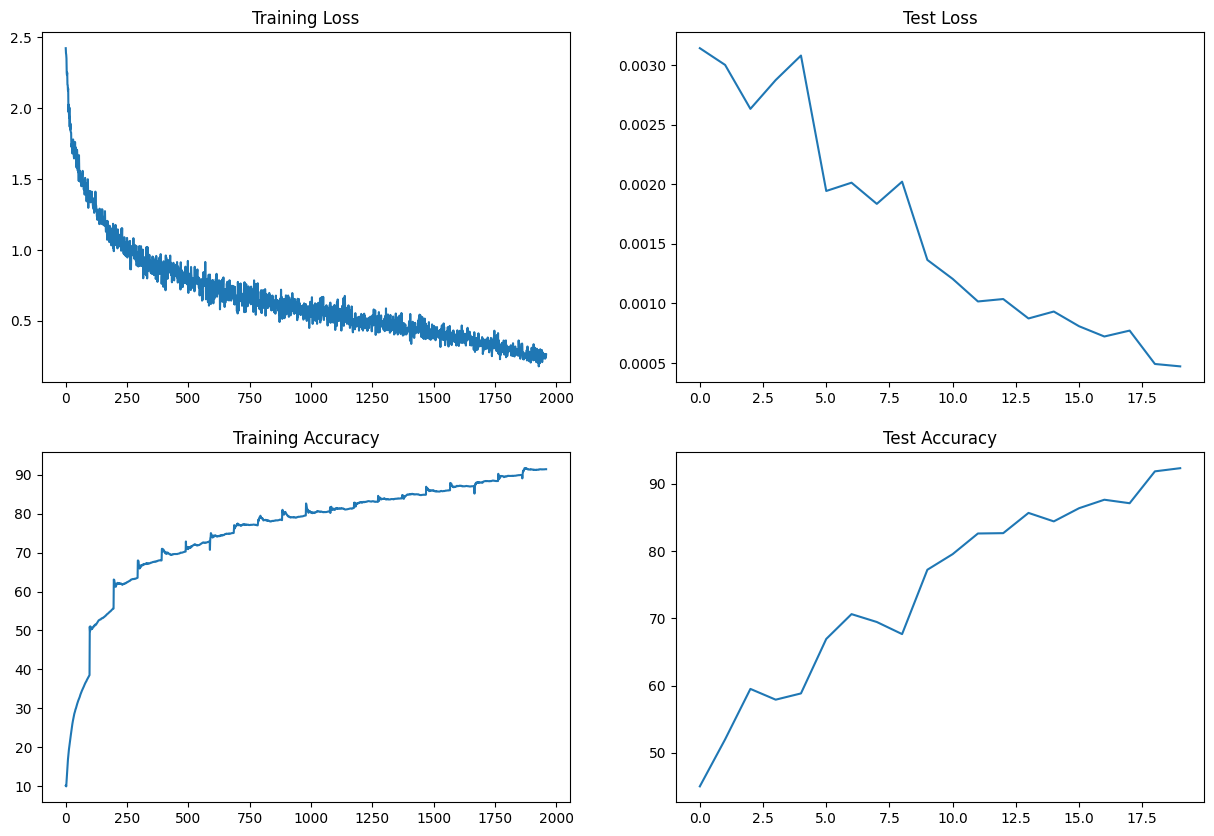

In [9]:
os.system('mkdir images')
fig = plot_losses(train_losses, train_acc, test_losses, test_acc)
fig.savefig('images/Accuracy & Loss.jpg')

## Displaying Sample Miss Classified Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

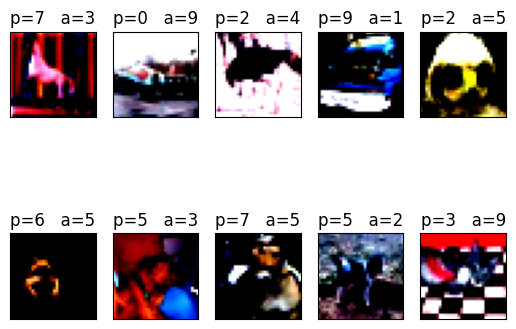

In [10]:
miss_classified_images = display_mis_images(miss_classified_data,10)
miss_classified_images.savefig("images/miss_class.jpg")

## Displaying Sample Train Dataset after trasformation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

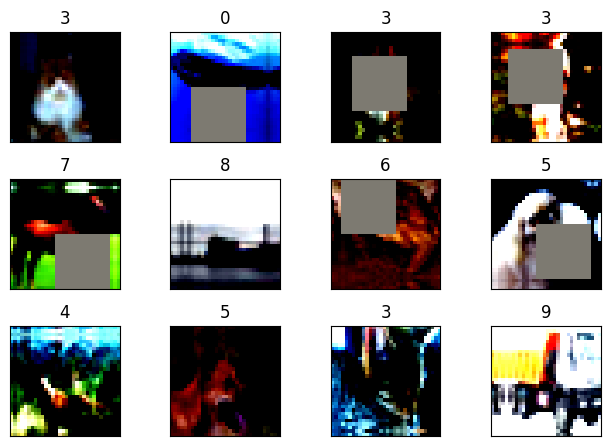

In [11]:
batch_data_train, batch_label_train = next(iter(train_loader))
figure_train = plot_images(batch_data_train, batch_label_train.tolist(), 12, 3, 'CIFAR10')
figure_train.savefig("images/train_dataset.jpg")

## Displaying Sample Test Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

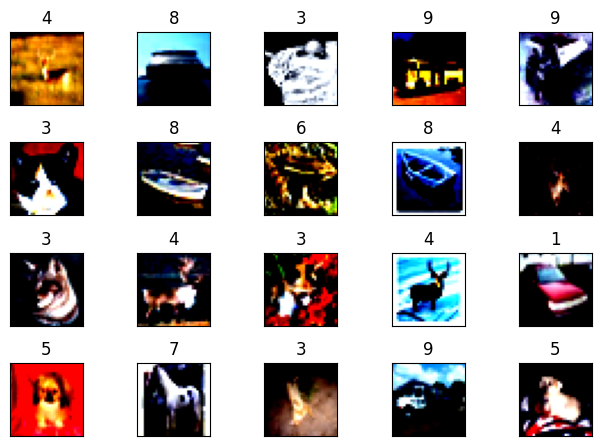

In [12]:
batch_data_test, batch_label_test = next(iter(test_loader))
figure_test = plot_images(batch_data_test, batch_label_test.tolist(), 20, 4, 'CIFAR10')
figure_test.savefig("images/test_dataset.jpg")

## Grad Cam Images

In [13]:

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
import numpy as np

In [14]:
model = m
target_layers = [m.layer4[-1]]

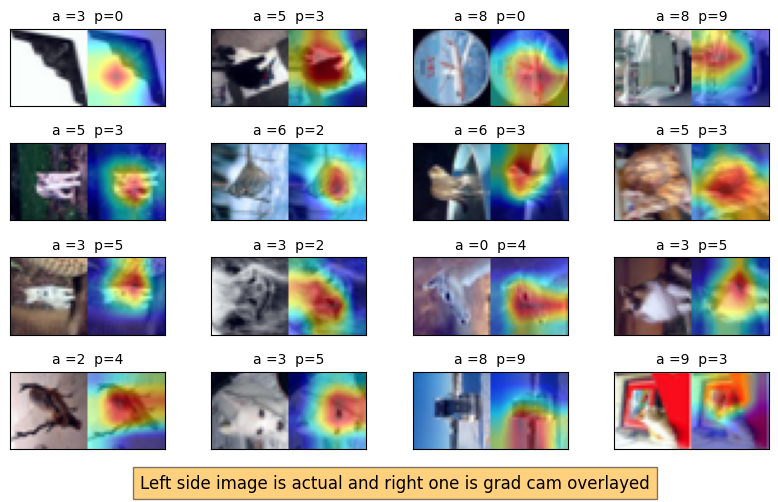

In [15]:
fig = plt.figure(figsize=(8,5))
for i in range (0,16):
    plt.subplot(4,int(16/4),i+1)
    plt.tight_layout()
    input_tensor = miss_classified_data[2][i].unsqueeze(0) 
    img = miss_classified_data[2][i].permute(1,2,0).cpu()
    img = img / 2.0 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 0, 2))
    npimg = (npimg - np.min(npimg)) / (np.max(npimg) - np.min(npimg))


    targets = [ClassifierOutputTarget(miss_classified_data[0][i])]

    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cams = cam(input_tensor=input_tensor, targets=targets)
        cam_image = show_cam_on_image(npimg,grayscale_cams[0, :], use_rgb=True)
    

    cam = np.uint8(255*grayscale_cams[0, :])
    #cam = cv2.merge([cam, cam, cam])
    images = np.hstack((np.uint8(255*npimg), cam_image))
    plt.imshow(np.uint8(255*npimg))
    plt.imshow(images)
    plt.xticks([])
    plt.yticks([])
    plt.title("a ="+str(miss_classified_data[0][i])+"  p="+str(miss_classified_data[1][i]),fontsize = 10)
plt.figtext(0.5, 0.01, "Left side image is actual and right one is grad cam overlayed", ha="center", fontsize=12, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})
plt.savefig("images/grad_cam.png")